In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.style.use('seaborn-whitegrid')

from utils import PkdbModel, ccolors ,markers,category_filter,filter_df,\
    abs_idx,rel_idx,group_idx,individual_idx \

plt.rcParams.update({
        'axes.labelsize': '20',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': '20',
        'xtick.labelsize': '20',
        'ytick.labelsize': '20',
        'figure.facecolor': '1.00'
    })


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.read()
caffeine_clearance = caffeine_clr.data
caffeine_clearance.groupby("study")

In [4]:
caffeine_clearance["outlier"] = False
caffeine_clearance.loc[caffeine_clearance["study"]== "Balogh1992","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1988","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1989","outlier"] = True

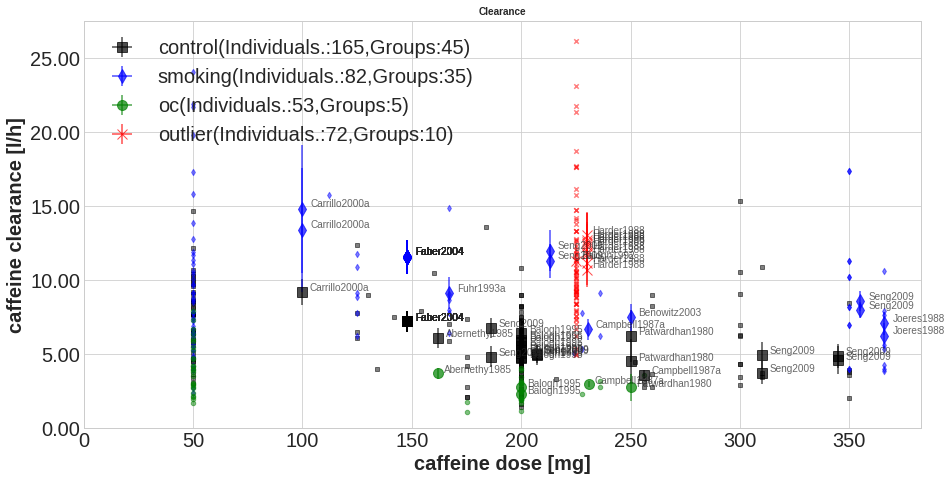

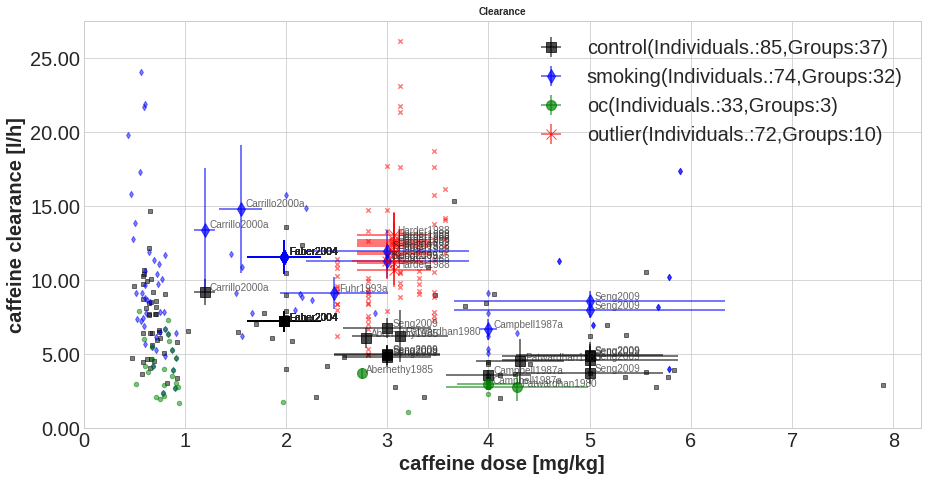

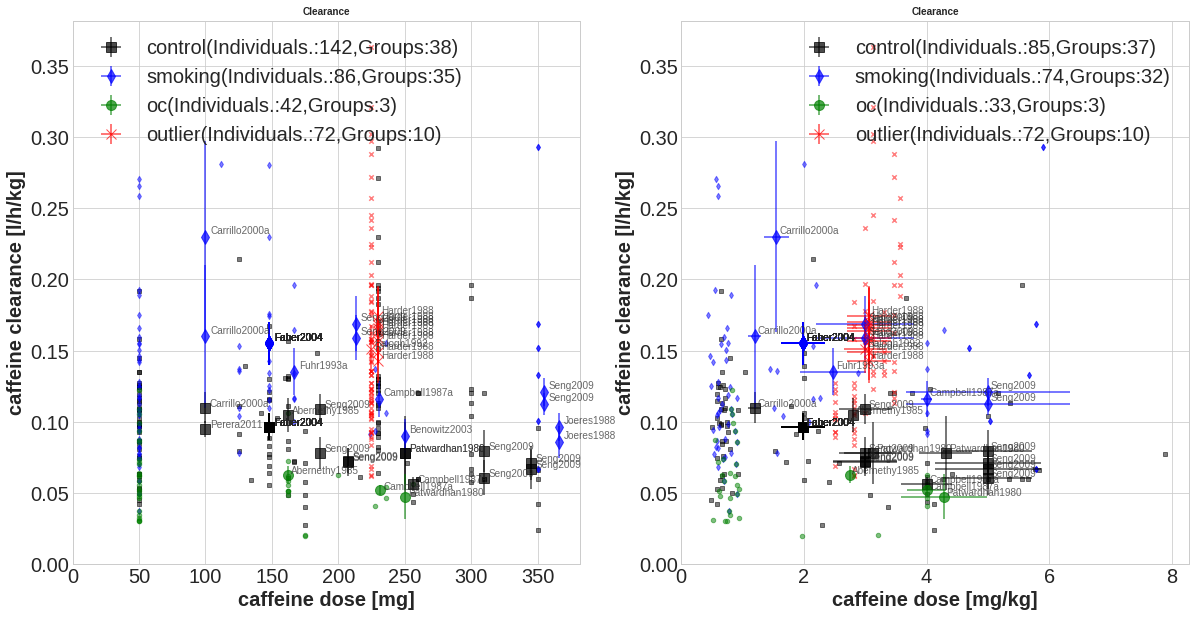

In [5]:
#caffeine_clearance=caffeine_clearance.groupby("study").get_group("Park2003")
# caffeine clearance
fig05, ax1, = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
fig1, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))

fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
dinds = [abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
         rel_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
         abs_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit"),
         rel_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit")]

for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
    df = caffeine_clearance[inds & individual_idx(caffeine_clearance)]
    df_group = caffeine_clearance[inds & group_idx(caffeine_clearance)]

    for category in ccolors:
        cf_filter = category_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        y = df_category["value"]
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], alpha=0.5,label=None,  s=20)
        units = df_category["unit"].unique()
        unit_intervention = df_category["unit_intervention"].unique()

        assert len(units) <= 1, units
        try:
            ax.set_ylabel(f'caffeine clearance [{units[0]}]')
            ax.set_xlabel(f'caffeine dose [{unit_intervention[0]}]')
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        except IndexError: 
            pass
        
        df_category = filter_df(cf_filter,df_group)
        df_category = df_category[df_category["mean"].notnull()]

        x_group = df_category["value_intervention"]
        y_group = df_category["mean"]
        #count_group = list(df_category[("weight","count")])
        if ax in (ax2, ax4):
            xerr_group = (df_category[("weight","sd")]/df_category[("weight","mean")])*x_group
        else:
            xerr_group = 0
        yerr_group = df_category["se"]

        ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=xerr_group,color=ccolors[category], fmt=markers[category],  label=f"{category}(Individuals.:{len(x)},Groups:{len(x_group)})",ms=10, alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x_group.iloc[[i]]+(0.01*x_group.max()),
                              y_group.iloc[[i]]+(0.01*y_group.max())), alpha=0.7)
        
for ax in (ax1, ax2, ax3, ax4):

    ax.set_title('Clearance')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.legend()

fig1.savefig("reports/caf_cl_01.svg", bbox_inches="tight")


In [6]:
#caffeine_clearance[abs_idx][["value_intervention","unit","subject_type","mean","sd"]]
df_group = caffeine_clearance[dinds[0] & group_idx(caffeine_clearance)]
df_category = filter_df(category_filter["control"],df_group)


In [7]:
df_group[('sex', 'count')]

21           12
75       (1, 6)
162           7
164         NaN
166         NaN
168      (5, 7)
170      (5, 7)
189      (2, 4)
190      (2, 4)
221          12
354          20
355          20
356          20
357          20
358          20
359          20
360          20
361          20
362          20
363          20
1490          4
1491          4
1492          4
1493          4
1494          4
1496         59
1498         59
1500         59
1502         59
1504         59
         ...   
1596     (4, 8)
1597     (4, 8)
1598     (4, 8)
1599     (4, 8)
1600     (4, 8)
1601     (4, 8)
1602     (4, 8)
1603     (4, 8)
1604     (4, 8)
1605     (4, 8)
1606     (5, 7)
1607     (5, 7)
1608         13
1609          9
1610          9
1611         10
1618         18
1619         18
1620        NaN
1621        NaN
1624         12
1699          5
1700         59
1701         59
1702         59
1703         59
1704         59
1705         59
1706     (1, 4)
1707    (2, 13)
Name: (sex, count), Leng